### Introduction

This is a school project for my Student Initiated Learning (SIL), in which I chose to do Financial Modelling 🤦‍♂️

The aim of this project is to build a model to assess the credit risk of borrowers.

Regression Trees are used for feature selection while both XGBoost and Random Forests are the main ML Algorithms used.

### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preprocessing (install & load libraries)

In [ ]:
# install libraries
# !pip install tensorflow
# !pip install torch torchvision
# !pip install pandas numpy scikit-learn matplotlib

In [ ]:
# load & import libraries
import pandas as pd
import numpy as np
import torch
import sklearn as sk
import matplotlib.pyplot as plt

### Getting to know our Data

In [ ]:
# load dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/credit_risk_dataset.csv")

In [ ]:
# getting to know the data better
#print(data.shape)
#print(data.dtypes)
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
print(data.describe())

         person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%   

####The more the loan amount, the more likely the loan will be defaulted?

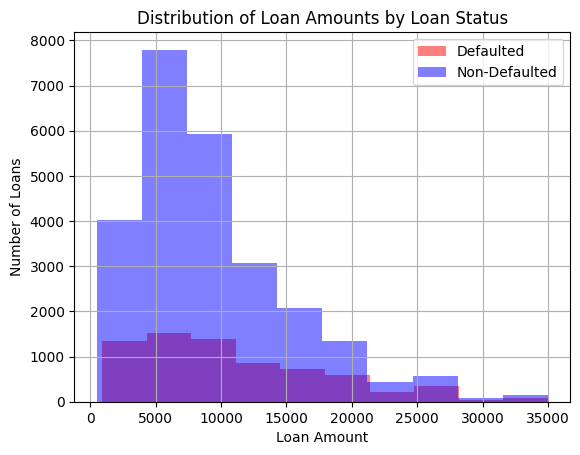

In [ ]:
# plot data
defaulted_loans = data[data["loan_status"] == 1]
non_defaulted_loans = data[data["loan_status"] == 0]

plt.hist(defaulted_loans['loan_amnt'], color='red', alpha=0.5, label='Defaulted')
plt.hist(non_defaulted_loans['loan_amnt'], color='blue', alpha=0.5, label='Non-Defaulted')

plt.xlabel('Loan Amount')
plt.ylabel('Number of Loans')
plt.title('Distribution of Loan Amounts by Loan Status')
plt.legend()
plt.grid(True)
plt.show()

This shows that how likely you are to default your loans doens't depend on the amount of your loan, since the shape of the 2 histograms are quite similar.

### Data Cleaning

#### Check which data has empty values

In [ ]:
# check missing values
print(data.isnull().sum())

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


Seems like a lot of data in loan interest rate (loan_int_rate) is missing. And this is important data as it will likely affect the default rate.

So, I will select all data where loan_int_rate is missing to see if there are any correlation.

In [ ]:
# split int missing rates data & contain rates data
missing_rates_data = data[data["loan_int_rate"].isnull()]
contain_rates_data = data[data["loan_int_rate"].notnull()]

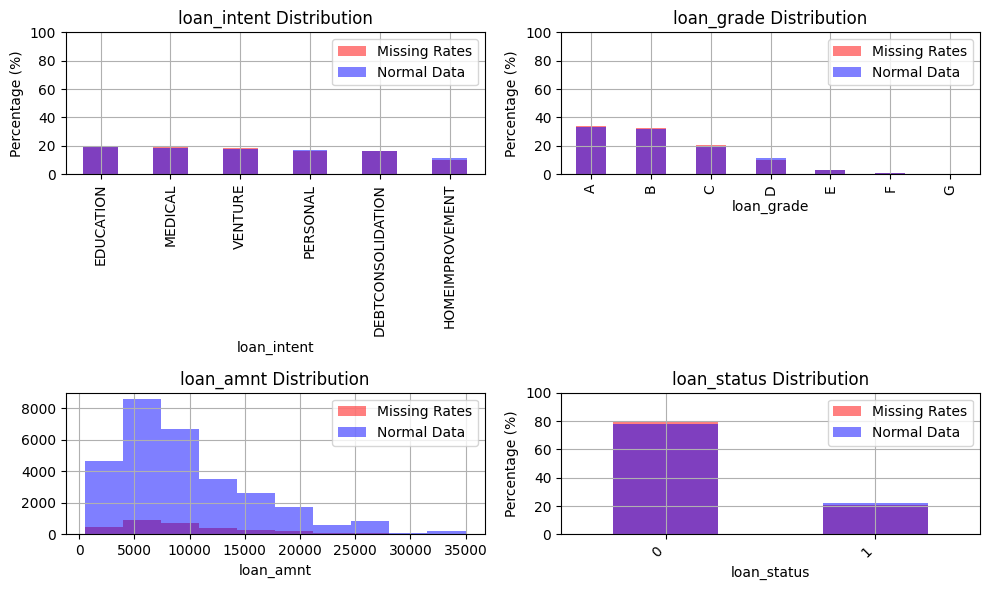

In [ ]:
# features I want to compare
features = ['loan_intent', 'loan_grade', 'loan_amnt', 'loan_status']
row = 0
col = 0

# create subplots
fig, axes = plt.subplots(2, 2, figsize=(10,6))

# main loop to fill subplots
for feature in features:
  ax = axes[row, col]

  if feature == 'loan_amnt':
    ax.hist(missing_rates_data[feature], color='red', alpha=0.5, label='Missing Rates')
    ax.hist(contain_rates_data[feature], color='blue', alpha=0.5, label='Normal Data')
  else:
    # Calculate percentage counts for categorical features
    total_missing = len(missing_rates_data)
    total_normal = len(contain_rates_data)
    missing_rates_data_pct = missing_rates_data[feature].value_counts(normalize=True) * 100  # Percentages for missing data
    contain_rates_data_pct = contain_rates_data[feature].value_counts(normalize=True) * 100  # Percentages for normal data

    # Plot bar charts with percentages
    missing_rates_data_pct.plot(kind='bar', color='red', alpha=0.5, ax=ax, label='Missing Rates')
    contain_rates_data_pct.plot(kind='bar', color='blue', alpha=0.5, ax=ax, label='Normal Data')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

    # Adjust y-axis limits and label for percentages
    ax.set_ylim(0, 100)
    ax.set_ylabel('Percentage (%)')

  # Set labels and title for each subplot
  ax.set_xlabel(feature)
  ax.set_title(f'{feature} Distribution')
  ax.legend()
  ax.grid(True)

  # Update row and col for the next subplot
  col += 1
  if col > 1:
    row += 1
    col = 0

plt.tight_layout()
plt.show()

The data with missing interest rate details are also pretty similar with the other data containing interest rate details.

For simplicity, I could just remove all of the data with empty interest rates, but it is a lot of data missing, so I will just replace them with the median interest rate (which works just as well).

#### Filling mean interest rate to rows with empty loan_int_rate  

In [ ]:
data['person_emp_length'].fillna(data['person_emp_length'].median(), inplace = True)
data['loan_int_rate'].fillna(data['loan_int_rate'].median(), inplace = True)

In [ ]:
print(data.isnull().sum())

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


Now that our data has no missing values, we have to remove the outliers. When I was exploring the data, I noticed a some outliers (120 years of employment length in years??? really??)

#### Handling Outliers using z-scores

In [ ]:
#using z_scores
from scipy import stats
z_scores = stats.zscore(data.select_dtypes(include = [float, int]))
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
clean_data = data[filtered_entries]



In [ ]:
clean_data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3
11,21,10000,OWN,2.0,HOMEIMPROVEMENT,A,4500,8.63,1,0.45,N,2
19,24,10800,MORTGAGE,8.0,EDUCATION,B,1750,10.99,1,0.16,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32290,37,90000,MORTGAGE,11.0,DEBTCONSOLIDATION,A,4000,6.62,0,0.04,N,15
32292,38,200000,MORTGAGE,0.0,DEBTCONSOLIDATION,A,3000,7.68,0,0.01,N,12
32293,38,110000,MORTGAGE,5.0,MEDICAL,B,16000,11.99,0,0.15,N,13
32295,42,101000,MORTGAGE,6.0,DEBTCONSOLIDATION,F,25000,16.15,1,0.25,Y,14


Now, we have a dataset that is free from empty values, and we removed some outliers. So, this data is now clean!!!

### Machine Learning

#### Train Test Split

We first split our data into training and test datasets. 20% of the data will be used for testing (test_size = 0.2)


Also, note the get_dummies is for one hot encoding.

Essentially, instead of person_home_ownership which could be RENT or OWN or OTHER, we create a new column that says: This person rents. Or this person owns. Or this person neither rent or owns.  

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

# one hot encoding
clean_data = pd.get_dummies(clean_data, drop_first=True)

X = clean_data.drop(columns = ['loan_status'])
y = clean_data['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Feature Selection (Random Forest)

Then, we apply random forest and decision tree (their avg) to find how important each feature are to determine the loan_status. (How much correlation are there?)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rt_model = DecisionTreeClassifier(random_state = 42)
rt_model.fit(X_train, y_train)

# get the feature importance
rf_importance = rf_model.feature_importances_
rt_importance = rt_model.feature_importances_


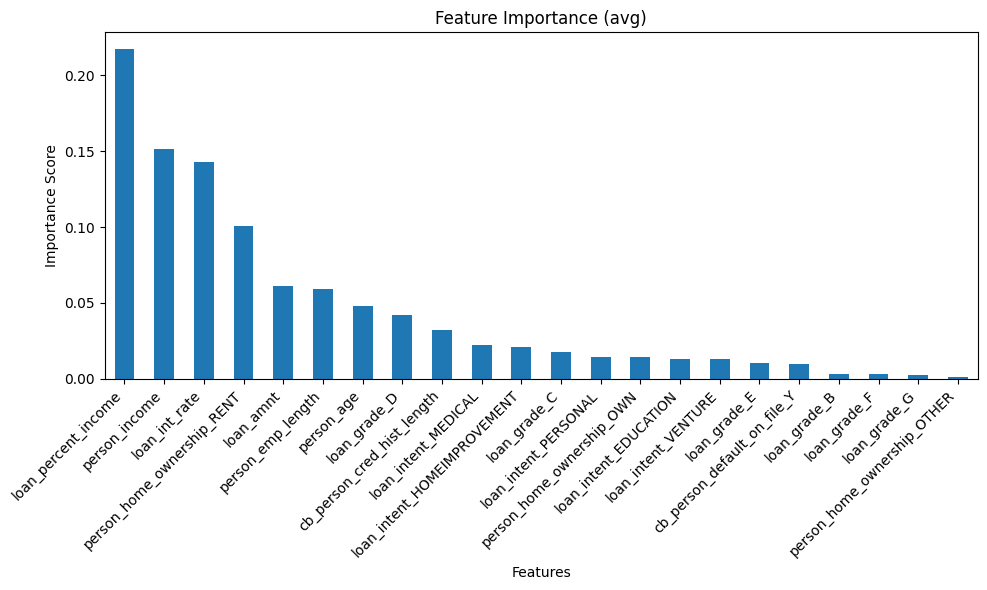

In [ ]:
# visualize feature importances
feature_names = X.columns.tolist()
importance_rf = pd.Series(rf_importance, index=feature_names)
importance_rt = pd.Series(rt_importance, index=feature_names)
combined_importance = pd.concat([importance_rf, importance_rt], axis=1, names=['Random Forest', 'Regression Tree'])

# sort by importance (average of both models)
combined_importance = combined_importance.mean(axis=1).sort_values(ascending=False)

# create a bar chart
plt.figure(figsize = (10,6))
combined_importance.plot(kind = 'bar')
plt.title("Feature Importance (avg)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation= 45, ha = 'right')
plt.tight_layout()
plt.show()

I can now select which features to use. And I will choose the first 6 features with the highest correlation.

In [ ]:
# features to use
features = ['loan_percent_income', 'person_income', 'loan_int_rate',
            'person_home_ownership_RENT', 'loan_amnt', 'person_emp_length']

#### Main part - XGBoost & Random Forest

I try to use both and find the one with the highest accuracy later, since XGBoost might overfit and become inaccurate.

In [ ]:
# train test split, using only features I want
X = clean_data[features]
y = clean_data['loan_status']

# normal train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# tts for valuation data (required for XGBoost, look at text below code chunk)
# and we take the valuation data from half of the testing data
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


# XGBoost
xgb_model = XGBClassifier(eval_metric='auc',  # Set evaluation metric (e.g., AUC)
                          early_stopping_rounds=10,  # Early stopping after 10 rounds of no improvement
                          random_state=42)

# fitting XGBoost, see the eval_set?
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Random Forest
rf_model = RandomForestClassifier(random_state = 42)
rf_model.fit(X_train, y_train)

[0]	validation_0-auc:0.87133
[1]	validation_0-auc:0.87900
[2]	validation_0-auc:0.88177
[3]	validation_0-auc:0.88322
[4]	validation_0-auc:0.88533
[5]	validation_0-auc:0.88706
[6]	validation_0-auc:0.88839
[7]	validation_0-auc:0.88896
[8]	validation_0-auc:0.89197
[9]	validation_0-auc:0.89352
[10]	validation_0-auc:0.89446
[11]	validation_0-auc:0.89572
[12]	validation_0-auc:0.89683
[13]	validation_0-auc:0.89747
[14]	validation_0-auc:0.90019
[15]	validation_0-auc:0.90045
[16]	validation_0-auc:0.90024
[17]	validation_0-auc:0.90314
[18]	validation_0-auc:0.90467
[19]	validation_0-auc:0.90789
[20]	validation_0-auc:0.90790
[21]	validation_0-auc:0.90870
[22]	validation_0-auc:0.90933
[23]	validation_0-auc:0.91108
[24]	validation_0-auc:0.91099
[25]	validation_0-auc:0.91155
[26]	validation_0-auc:0.91185
[27]	validation_0-auc:0.91190
[28]	validation_0-auc:0.91204
[29]	validation_0-auc:0.91259
[30]	validation_0-auc:0.91310
[31]	validation_0-auc:0.91397
[32]	validation_0-auc:0.91451
[33]	validation_0-au

RandomForestClassifier(random_state=42)

Apparently, XGBoost requires valuation data. So how it works is that the model will keep learning until suddenly the validation score no longer increases, then it stops. (No wonder it's called Extreme Gradient Boosting)

### Evaluate accuracy of the models

#### Accuracy of XGBoost Model:

In [ ]:
xgb_eval_results = xgb_model.evals_result_
final_validation_auc = xgb_eval_results['validation_0']['auc'][-1]
print("Final Validation AUC:", final_validation_auc)

Final Validation AUC: 0.9182457789806612


#### Accuracy of Random Forest Model:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Accuracy
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))

# Precision
rf_precision = precision_score(y_test, rf_model.predict(X_test))

# Recall
rf_recall = recall_score(y_test, rf_model.predict(X_test))

# F1-score
rf_f1 = f1_score(y_test, rf_model.predict(X_test))

# Print the evaluation metrics for Random Forest
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)
print("Random Forest F1-score:", rf_f1)

Random Forest Accuracy: 0.905440414507772
Random Forest Precision: 0.8950892857142857
Random Forest Recall: 0.6207430340557275
Random Forest F1-score: 0.73308957952468


**Explanation of each metric valuation:**

Accuracy - How many correct answers (in percentage)

Precision - True Positives / Total Positives

Recall - True Positives / Actual Positive

F1-score: This metric combines precision and recall into a single score, providing a balance between the two. It's calculated as the harmonic mean of precision and recall. (I dont understand this at all lmao)


### Conclusion

#### Final evaluation & what can be done as improvement

**These results are very good:** \
Random Forest Accuracy: 0.905440414507772 \
Random Forest Precision: 0.8950892857142857


**But this one is concerning:** \
Random Forest Recall: 0.6207430340557275

**According to AI, this is what it means:** \
My model is good at identifying true approved loans it predicts (precision), but it might be missing a substantial portion of actual approved loans (low recall).

**What is also means:** \
A model with low recall and high precision is more cautious. \
In case of our model, it has a very low risk of selecting people who might default, and only selects borrowers that are very likely to not default the loan. \
\
However, this might result in missed oppportunities for the bank and hence reducing revenue. But it is safer and has less risk, which is more suitable when (interest rates are low and a lot more people are more likely to take loans) <-- not sure.  

**What can I do to try and improve this?** \
Try to avoid too much bias when selecting features to train the model.

#### What I have learnt

This is my first time using ML algorithms other than Linear, Logistic Regression and K-means Clustering. \
I was forced to learn about the concepts behind the algorithms (Decision Tree, Random Forests, XGBoost) immediately and applying them made it a lot easier to understand. \
Still, I have yet to understand the maths behind these models, but that will come later.

Also, thank god I had ChatGPT and Gemini. Else I would have died in the process of making this (seriously).

I have learnt a lot during the process and I am glad I chose this topic.  \
Finally, I got to connect eveything about ML which had wrecked my brain since Year 1.  Yay!